In [164]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import pandas as pd


In [165]:
# SHARED
_k_b = scipy.constants.k
_rho = 4200
_rho_f = 789
_r =  2.6392235755368e-06
_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.36e-3
_v_force = 6*np.pi*_r*_viscous

_K = 8.061743253740993e-05
_gain = np.sqrt(335982165125421.5 )

bin_number_data = [70, 80, 90, 100, 110, 120]
timestep_data = [bn/200000000 for bn in bin_number_data]

In [166]:
# Calculate the average MSD
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

# Calculate the zero init MSD

def compute_init_msd(sequence):
    MS = np.zeros(len(sequence))
    for i in range(1, len(MS)):
        MS[i] = (sequence[0] - sequence[i])**2
        #print(np.abs(sequence[0] - sequence[1]) / np.abs(sequence[50] - sequence[55]))
    return MS

def compute_init_msd2(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd_ = [(time_trace[k]-time_trace[0])**2 for k in range(n)]
    return msd_, lag_times


In [167]:
# ANALYTICAL FUNCTIONS

# GENERAL WHITE NOISE
def msd_wn(t):
    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    return (2*_k_b*_temp/_K)*(1-np.exp(-t/(2*tau))*(np.cosh(omega_1*t)+(1/(2*omega_1*tau))*np.sinh(omega_1*t)))

# INITIALLY ZERO WHITE NOISE
def just_noise(t):

    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
    denominator = -2 + 8*tau**2*omega_1**2#-1*8*tau**2*omega_0**2
    final_scale = 12*np.pi*_r*_viscous*_k_b*_temp / _m**2 / omega_1**2
    return (numerator / denominator) * final_scale

# INITIAL SET VARIANCE WHITE NOISE
def known_initial_v_0(t, tol_percent):

    tau = _m / _v_force

    #Defines important auxillary variables

    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    T = omega_1*t

    #Gets contribution from the thermal white noise
    gamma = just_noise(t)

    #Gets contribution from initial position variation
    # hyp_factors = np.exp(-1*t/tau)*(np.cosh(T)**2 + 1/(4*(omega_1*tau)**2)*np.sinh(T)**2 + 1/(omega_1*tau)*np.cosh(T)*np.sinh(T)) - np.exp(-1*t/(2*tau))*(2*np.cosh(T) - 1/(2*omega_1*tau)*np.sinh(T))
    hyp_factors = (1 - np.exp(-t/(2*tau))*(np.cosh(omega_1*t) + np.sinh(omega_1*t)/(2*omega_1*tau)))**2

    #alpha easier to type than tol_percent
    alpha = tol_percent

    #Gets the second moment of the velocity assuming a probabiity distribution of
    #a Gaussian cut off on its wings by some fraction of its standard deviation (alpha/tol_percent)
    updated_sigma = 1 - alpha*np.exp(-alpha**2/2)*np.sqrt(2/np.pi)/scipy.special.erf(alpha/np.sqrt(2))

    #Calculates the contribution from the intitial velocity spread
    velo = np.exp(-1*t/tau) / omega_1**2 * np.sinh(omega_1*t)**2 *_k_b*_temp / _m * updated_sigma

    #Puts the pieces together
    return _k_b*_temp / _K * ( hyp_factors) + gamma + velo

# HYDRODYNAMIC GENERAL CASE
def hydro_msd(t):
    trap_const = _K
    use_mass = _m
    m_f = 2 / 3 * np.pi * _r ** 3 * 1000
    t_k = (6 * np.pi * _r * _viscous) / _K
    t_f = (_rho_f * _r ** 2) / _viscous
    t_p = _m / (6 * np.pi * _r * _viscous)
    print("tp is " + str(t_p))
    print(t_f)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = _k_b * _temp / (6 * np.pi * _viscous * _r)
    # Returns theoretical MSD
    return np.real(2 * _k_b * _temp / trap_const + 2 * _k_b * _temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))



In [229]:
# LOOK FOR SPECIFIC SPEEDS
# SIM PART 3

speeds = [0, .5, 1]

data_speeds_msds_bin = [[] for x in bin_number_data]

speed_tol = [.015, .015, .015]
lag_times_speed_data = [[] for m in range(len(bin_number_data))]
all_idx = []
save_traces_data = []

for b in range(len(bin_number_data)):
    # DATA
    traces_per_speed = [0, 0, 0]
    idx_per_bin = []
    chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
    chunks1 = []
    
    for chunk in pd.read_csv(fr'C:\Users\Cole Thumann\PycharmProjects\Brownian_Data_Analysis\data\barium_titanate_in_acetone_position_bin{bin_number_data[b]}.csv', chunksize=chunksize, low_memory=False):
        # process each chunk individually or filter/aggregate it
        chunks1.append(chunk)
    
    data_df_pos_data = pd.concat(chunks1, ignore_index=True)
    
    chunks2 = []
    
    for chunk in pd.read_csv(fr'C:\Users\Cole Thumann\PycharmProjects\Brownian_Data_Analysis\data\barium_titanate_in_acetone_velocity_bin{bin_number_data[b]}.csv', chunksize=chunksize, low_memory=False):
        # process each chunk individually or filter/aggregate it
        chunks2.append(chunk)
    
    data_df_vel_data = pd.concat(chunks2, ignore_index=True)
    
    # Convert DataFrame into a numpy array where each column is an entry
    traces_data = data_df_pos_data.to_numpy().T  # transpose if you want each col as an entry
    
    # Convert DataFrame into a numpy array where each column is an entry
    v_traces_data = data_df_vel_data.to_numpy().T  # transpose if you want each col as an entry
    
    if b==0 or b==5:
        save_traces_data.append(traces_data)
    
    # GET THE EQ MSD
    all_msd_data = []
    lag_times_data = 0
    for series in traces_data:
        msd, lag_times_data = compute_msd(series, timestep_data[b])
        all_msd_data.append(msd)
    
    eq_msd_data = np.mean(all_msd_data, axis=0)

    for s in range(len(speeds)):
        idx_per_speed =[]
        all_speeds_msd_data = []
        init_len_data = int(len(traces_data[0])/10)
                
        for i in range(len(traces_data)):
            speed_idxs_data = []
            print("std of data vel " + str(np.std(v_traces_data[i])))
            v_tolerance = (speeds[s] * np.std(v_traces_data[i]))
            speed_tolerance = speed_tol[s] * np.std(v_traces_data[i])
            v_indices_data = np.where((v_traces_data[i] < v_tolerance + speed_tolerance) & (v_traces_data[i] > v_tolerance - speed_tolerance))[0]
            print("speed idx data: " + str(len(v_indices_data)))
    
            for idx in v_indices_data:
                if idx + init_len_data < len(traces_data[i]):
                    speed_idxs_data.append(idx)
    
            print("total idx data: " + str(len(speed_idxs_data)))
            traces_per_speed[s] += len(speed_idxs_data)
            for idx in speed_idxs_data:
                msd, lag_times_speed_data[b] = compute_init_msd2(traces_data[i][idx:idx+init_len_data], timestep_data[b])
                all_speeds_msd_data.append(msd)
            idx_per_speed.append(speed_idxs_data)
        print(f"-------TOTAL TRACES DATA {traces_per_speed[s]}------------")
        speed_msd_data = np.mean(all_speeds_msd_data, axis=0)
        data_speeds_msds_bin[b].append(speed_msd_data)
        idx_per_bin.append(idx_per_speed)
    all_idx.append(idx_per_bin)
    

100%|██████████| 119837/119837 [00:04<00:00, 25371.08it/s]


std of data vel 1965.7331425314749
speed idx data: 1376
total idx data: 1225
std of data vel 2050.576796604645
speed idx data: 1434
total idx data: 1304
std of data vel 2043.76855060788
speed idx data: 1479
total idx data: 1304
std of data vel 2016.2973431227056
speed idx data: 1468
total idx data: 1328
std of data vel 2121.906805133682
speed idx data: 1467
total idx data: 1305
std of data vel 2183.487717267069
speed idx data: 1533
total idx data: 1376
std of data vel 2019.1188587614606
speed idx data: 1469
total idx data: 1287
-------TOTAL TRACES DATA 9129------------
std of data vel 1965.7331425314749
speed idx data: 1353
total idx data: 1218
std of data vel 2050.576796604645
speed idx data: 1341
total idx data: 1208
std of data vel 2043.76855060788
speed idx data: 1306
total idx data: 1161
std of data vel 2016.2973431227056
speed idx data: 1253
total idx data: 1122
std of data vel 2121.906805133682
speed idx data: 1175
total idx data: 1071
std of data vel 2183.487717267069
speed idx

100%|██████████| 104857/104857 [00:04<00:00, 22551.14it/s]


std of data vel 1901.4722886215009
speed idx data: 1200
total idx data: 1072
std of data vel 1978.3941758419107
speed idx data: 1283
total idx data: 1153
std of data vel 1971.2821993530665
speed idx data: 1251
total idx data: 1101
std of data vel 1953.2316031649254
speed idx data: 1225
total idx data: 1077
std of data vel 2030.6046941174932
speed idx data: 1281
total idx data: 1144
std of data vel 2076.5620182561747
speed idx data: 1226
total idx data: 1085
std of data vel 1960.4090526697466
speed idx data: 1294
total idx data: 1156
-------TOTAL TRACES DATA 7788------------
std of data vel 1901.4722886215009
speed idx data: 1090
total idx data: 976
std of data vel 1978.3941758419107
speed idx data: 1168
total idx data: 1058
std of data vel 1971.2821993530665
speed idx data: 1127
total idx data: 990
std of data vel 1953.2316031649254
speed idx data: 1093
total idx data: 982
std of data vel 2030.6046941174932
speed idx data: 1095
total idx data: 987
std of data vel 2076.5620182561747
spe

100%|██████████| 93206/93206 [00:03<00:00, 29869.41it/s]


std of data vel 1861.9411127595922
speed idx data: 1151
total idx data: 1049
std of data vel 1923.908172164391
speed idx data: 1192
total idx data: 1075
std of data vel 1928.6255114836158
speed idx data: 1140
total idx data: 1029
std of data vel 1918.1801694711955
speed idx data: 1137
total idx data: 1004
std of data vel 1974.1750574217522
speed idx data: 1159
total idx data: 1049
std of data vel 2010.2585996899707
speed idx data: 1108
total idx data: 991
std of data vel 1918.286922293871
speed idx data: 1135
total idx data: 996
-------TOTAL TRACES DATA 7193------------
std of data vel 1861.9411127595922
speed idx data: 980
total idx data: 886
std of data vel 1923.908172164391
speed idx data: 920
total idx data: 819
std of data vel 1928.6255114836158
speed idx data: 1038
total idx data: 910
std of data vel 1918.1801694711955
speed idx data: 1040
total idx data: 952
std of data vel 1974.1750574217522
speed idx data: 903
total idx data: 807
std of data vel 2010.2585996899707
speed idx da

100%|██████████| 83886/83886 [00:02<00:00, 29894.29it/s]


std of data vel 1834.4060724077117
speed idx data: 1013
total idx data: 922
std of data vel 1892.2530632257933
speed idx data: 1015
total idx data: 910
std of data vel 1898.6239859632453
speed idx data: 1020
total idx data: 904
std of data vel 1890.9636558764332
speed idx data: 1036
total idx data: 932
std of data vel 1939.1198645023321
speed idx data: 1001
total idx data: 917
std of data vel 1964.4597549139794
speed idx data: 1029
total idx data: 910
std of data vel 1893.0286210607708
speed idx data: 996
total idx data: 898
-------TOTAL TRACES DATA 6393------------
std of data vel 1834.4060724077117
speed idx data: 906
total idx data: 815
std of data vel 1892.2530632257933
speed idx data: 839
total idx data: 759
std of data vel 1898.6239859632453
speed idx data: 864
total idx data: 783
std of data vel 1890.9636558764332
speed idx data: 848
total idx data: 776
std of data vel 1939.1198645023321
speed idx data: 856
total idx data: 766
std of data vel 1964.4597549139794
speed idx data: 8

100%|██████████| 76260/76260 [00:02<00:00, 33624.67it/s]


std of data vel 1815.8607465071605
speed idx data: 898
total idx data: 805
std of data vel 1873.747019607825
speed idx data: 952
total idx data: 837
std of data vel 1880.2406919832515
speed idx data: 924
total idx data: 833
std of data vel 1864.0197362257798
speed idx data: 952
total idx data: 856
std of data vel 1913.8616213069467
speed idx data: 908
total idx data: 822
std of data vel 1951.9486702433776
speed idx data: 947
total idx data: 832
std of data vel 1881.643714276668
speed idx data: 937
total idx data: 819
-------TOTAL TRACES DATA 5804------------
std of data vel 1815.8607465071605
speed idx data: 824
total idx data: 747
std of data vel 1873.747019607825
speed idx data: 845
total idx data: 766
std of data vel 1880.2406919832515
speed idx data: 854
total idx data: 757
std of data vel 1864.0197362257798
speed idx data: 821
total idx data: 747
std of data vel 1913.8616213069467
speed idx data: 801
total idx data: 711
std of data vel 1951.9486702433776
speed idx data: 846
total 

100%|██████████| 69905/69905 [00:01<00:00, 36745.38it/s]


std of data vel 1802.2019910597598
speed idx data: 797
total idx data: 725
std of data vel 1859.898630485672
speed idx data: 789
total idx data: 700
std of data vel 1865.1724893671926
speed idx data: 842
total idx data: 764
std of data vel 1850.2078284621412
speed idx data: 824
total idx data: 751
std of data vel 1895.1135904572095
speed idx data: 840
total idx data: 761
std of data vel 1912.488017359124
speed idx data: 841
total idx data: 753
std of data vel 1863.4655147745834
speed idx data: 751
total idx data: 673
-------TOTAL TRACES DATA 5127------------
std of data vel 1802.2019910597598
speed idx data: 775
total idx data: 683
std of data vel 1859.898630485672
speed idx data: 750
total idx data: 675
std of data vel 1865.1724893671926
speed idx data: 731
total idx data: 640
std of data vel 1850.2078284621412
speed idx data: 784
total idx data: 710
std of data vel 1895.1135904572095
speed idx data: 713
total idx data: 645
std of data vel 1912.488017359124
speed idx data: 714
total i

In [230]:
import math
from scipy import constants

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def experfc_inverse_form(t, tau, roots):
    return np.real((1/_m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)
#
def stat_hydro_msd(t, roots):
    return 2*constants.k*_temp*c_inverse_form(t, roots)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))



In [231]:
times_analytic = np.logspace(-6.5, -2.5, 1000)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 500

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))
#
# for i in range(num_samples):
#     results[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], 0, roots, _temp)

speeds_analytic = []
speeds_analytic_no_half = []
for speed in speeds:
    print("Speed X")
    for i in range(num_samples):
        results_speed[i, :] = stat_hydro_msd(times_analytic, roots)
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.sqrt(_k_b*_temp/_m))
    speeds_analytic.append(results_speed.mean(axis=0))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
    results_speed = np.zeros((num_samples, len(times_analytic)))
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))

averaged_initial_msd = results.mean(axis=0)


Speed X


C:\Users\Cole Thumann\AppData\Local\Temp\ipykernel_34044\3586738553.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  results_speed[i, :] = stat_hydro_msd(times_analytic, roots)


Speed X
Speed X


In [232]:
print(data_speeds_msds_bin)

[[array([0.00000000e+00, 1.25268462e-07, 5.58747453e-07, ...,
       3.27894038e-02, 3.27911216e-02, 3.27923291e-02]), array([0.00000000e+00, 2.35556415e-07, 8.74615451e-07, ...,
       3.23370524e-02, 3.23363915e-02, 3.23418115e-02]), array([0.00000000e+00, 5.67690193e-07, 1.78640735e-06, ...,
       3.35221437e-02, 3.35226910e-02, 3.35194000e-02])], [array([0.00000000e+00, 1.25788532e-07, 5.57973230e-07, ...,
       3.32284599e-02, 3.32291668e-02, 3.32263432e-02]), array([0.00000000e+00, 2.61082545e-07, 1.00363200e-06, ...,
       3.23793976e-02, 3.23769545e-02, 3.23794394e-02]), array([0.00000000e+00, 6.72479473e-07, 2.27172302e-06, ...,
       3.18506492e-02, 3.18506021e-02, 3.18516213e-02])], [array([0.00000000e+00, 1.24021160e-07, 5.81726647e-07, ...,
       3.20983646e-02, 3.21013053e-02, 3.20983540e-02]), array([0.00000000e+00, 2.90572895e-07, 1.12867442e-06, ...,
       3.25528977e-02, 3.25442719e-02, 3.25383648e-02]), array([0.00000000e+00, 8.33005266e-07, 2.84523954e-06, ...

tp is 1.9754935012178625e-05
1.5266056537325107e-05


<Figure size 1000x1000 with 0 Axes>

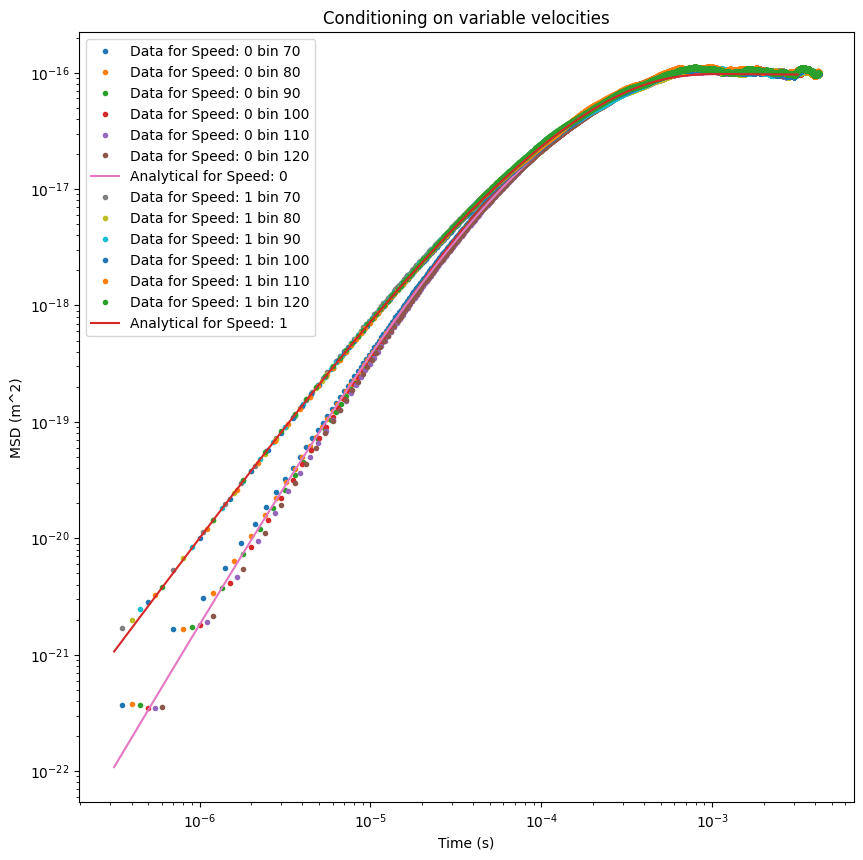

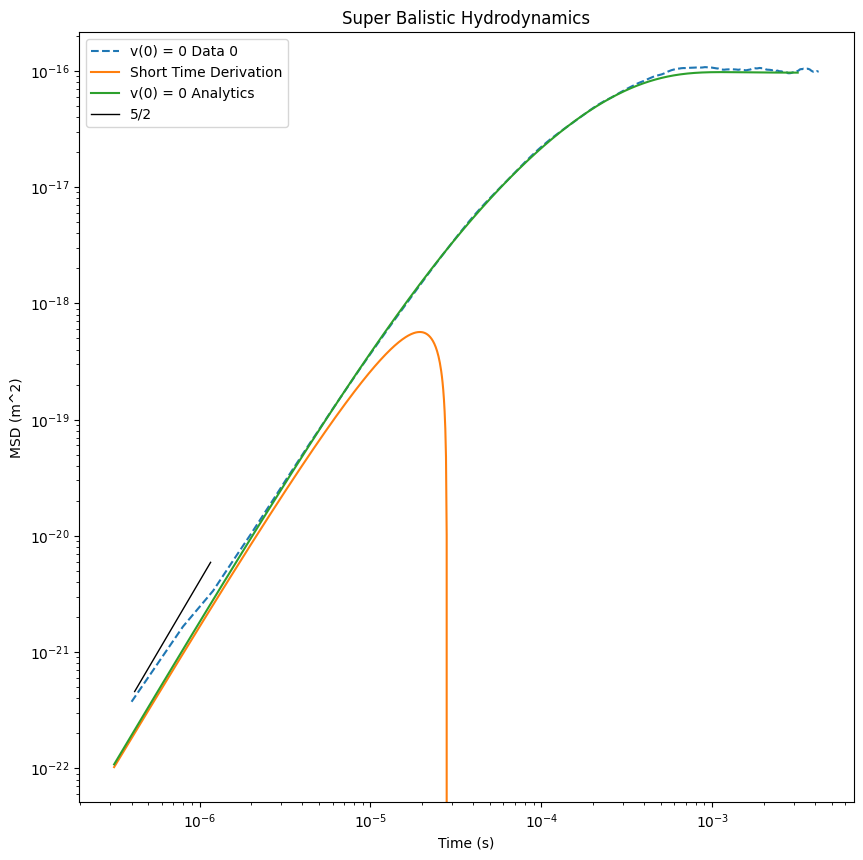

In [233]:
# GRAPHING
plt.figure(figsize=(10,10))

#  Set times for analytic functions

init_zero_WN_analytic = just_noise(times_analytic)
WN_EQ_analytic = msd_wn(times_analytic)
basset_msd = hydro_msd(times_analytic)

def form_func(times):
    return (2/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force)) - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_5_2(times):
    return (4/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_2(times):
    return (2/100)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)

plt.figure(figsize=(10,10))

# SPEEDS
for i in [0,2]:
    # plt.plot(lag_times_speed_data[1:], data_speeds_msds[i][1:]/_gain**2, linestyle = 'dashed', label=f"Data for Speed: {speeds[i]}")
    for j in range(len(bin_number_data)):
        plt.plot(lag_times_speed_data[j][1:], data_speeds_msds_bin[j][i][1:]/_gain**2, ".", label=f"Data for Speed: {speeds[i]} bin {bin_number_data[j]}")
    plt.plot(times_analytic, speeds_analytic_no_half[i], label=f"Analytical for Speed: {speeds[i]}")

plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("Conditioning on variable velocities")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# ZERO PLOT
plt.figure(figsize=(10,10))
# plt.plot(lag_times_speed_data[1:], data_speeds_msds[0][1:]/_gain**2, linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[0]}")
plt.plot(lag_times_speed_data[1][1:], data_speeds_msds_bin[1][0][1:]/_gain**2, linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[0]}")
plt.plot(times_analytic, form_func(times_analytic), label= "Short Time Derivation")
plt.plot(times_analytic, speeds_analytic_no_half[0], label=f"v(0) = 0 Analytics")
plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/7)])), label="5/2", color='black', linewidth=1)
plt.title("Super Balistic Hydrodynamics")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



bin 70 has len 1225
bin 80 has len 1072
bin 90 has len 1049
bin 100 has len 922
bin 110 has len 805
bin 120 has len 725


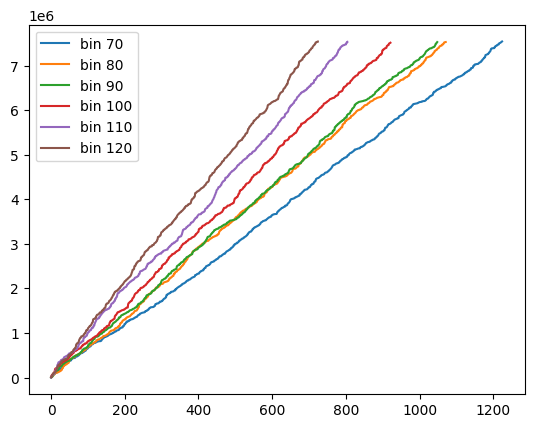

1225
out: 171
725
out: 164


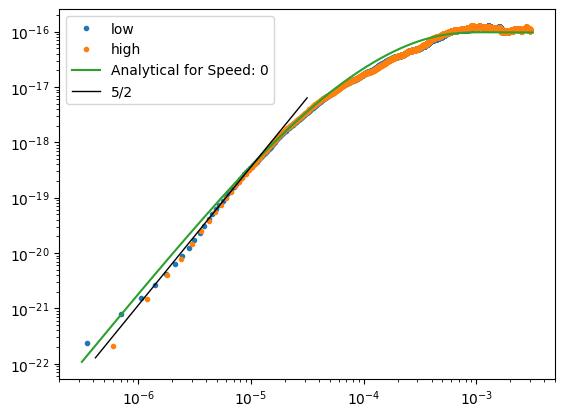

In [247]:
# all idx--
#          |-idx per bin
#          |-idx per bin--- idx per speed
#                          |- idx per speed--
#                                            |-idx per trace
#                                            |-idx per trace

for i in range(len(all_idx)):
    plt.plot(bin_number_data[i]* np.array(all_idx[i][0][0]), label=f"bin {bin_number_data[i]}")
    print(f"bin {bin_number_data[i]} has len {len(all_idx[i][0][0])}")
plt.legend()
plt.show()

def shared_points_with_tolerance(arr1, arr2, tol):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)

    # For each point in arr1, check if there's any point in arr2 within the tolerance
    mask = np.any(np.abs(arr1[:, None] - arr2) <= tol, axis=1)

    # Keep the values from arr1 that meet the condition
    return arr1[mask]


def mutual_matches_n(arrays, tol):
    arrays = [np.asarray(arr) for arr in arrays]
    n = len(arrays)
    
    # Convert all arrays to 2D column vectors for broadcasting
    arrays_col = [arr[:, None] for arr in arrays]

    # Create initial masks (all True)
    masks = [np.full(len(arr), True) for arr in arrays]

    for i in range(n):
        # For each array i, compare with all other arrays j ≠ i
        for j in range(n):
            if i == j:
                continue
            # Compute pairwise differences |A_i - A_j|
            diffs = np.abs(arrays[i][:, None] - arrays[j][None, :])  # shape (len(A_i), len(A_j))
            # Find if each element of A_i has *any* match in A_j
            has_match = np.any(diffs <= tol, axis=1)
            # Update mask: keep only values that match *all* other arrays
            masks[i] = masks[i] & has_match

    # Apply masks
    filtered = [arr[mask] for arr, mask in zip(arrays, masks)]
    return filtered

smudge = 500

# if its in all of them, count it
all_input = []
for i in [0,5]:#len(all_idx)):
    all_input.append(bin_number_data[i]*np.array(all_idx[i][0][0]))
    
all_output = mutual_matches_n(all_input, smudge)

for i in range(len(all_input)):
    print(len(all_input[i]))
    print(f"out: {len(all_output[i])}")
    
low_bin_idx = [int(a/bin_number_data[0]) for a in all_output[0]]
high_bin_idx = [int(a/bin_number_data[5]) for a in all_output[1]]

lags_low = 0
low_msds = []
for idx in low_bin_idx:
    msd, lags_low = compute_init_msd2(save_traces_data[0][0][idx:idx+5000], timestep_data[0])
    low_msds.append(msd)
low_msd = np.mean(low_msds, axis=0)

lags_high = 0
high_msds = []
for idx in high_bin_idx:
    msd, lags_high = compute_init_msd2(save_traces_data[1][0][idx:idx+5000], timestep_data[5])
    high_msds.append(msd)
high_msd = np.mean(high_msds, axis=0)

plt.plot(lags_low, low_msd/_gain**2, ".", label='low')
plt.plot(lags_high, high_msd/_gain**2,".", label='high')
plt.plot(times_analytic, speeds_analytic_no_half[0], label=f"Analytical for Speed: {speeds[0]}")
plt.plot(times_analytic[30:int(len(times_analytic)/2)], .28*graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/2)])), label="5/2", color='black', linewidth=1)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
